### Notes: ###

- recommended lda package (https://pypi.org/project/lda/) uses collapsed gibs sampling
    - but looks not so powerful
- recommended gensim libary uses online variational inference
    - looks good, install: https://visualstudio.microsoft.com/de/visual-cpp-build-tools/ to use it
    - Also pyLDAvis has the same problem..
      
- Therefore we currently use scikit learn. It uses online variational inference



# Topic modeling with latent Dirichlet allocation (LDA) 

We will study the Reuters-21578 document collection, which contains news wire articles.

First we download and load the Reuters-21578 dataset using the *Natural Language Toolkit* (*NLTK*), which is a platform for handling natural language in Python. It provides access to several text corpora and functions for handling text data.

In [1]:
import nltk
import numpy as np
from nltk.corpus import reuters
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('reuters')
articles=[]
for doc_id in reuters.fileids():
    articles.append(reuters.raw(doc_id))

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


The variable $articles$ now contains 10788 documents in the form of strings.

LDA is a bag-of-words model. This means that for performing inference with the LDA model, it suffices to know which words appear in a document and how often each word appears. Therefore we will pass the document collection as a document word frequency matrix. The document word frequency matrix is a 2D array where rows represent documents and columns represent words and each cell counts how many times the specific word appears in a given document.

The following code constructs a document word matrix $tf$, pruning the vocabulary of words such that it only contains words  that:

* have latin characters and are of length 3 or more characters (token_pattern='[a-zA-Z]{3,}'),

* are not english stop words, that is, frequent but uninformative words such as "the" or "a" (stop_words='english')

* occur in at least 0.2% of all documents and at most 50% of all documents (max_df=0.70, min_df=0.002)

and out of these using the 2000 most frequent words (max_features=2000).

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
tf = CountVectorizer( token_pattern='[a-zA-Z]{3,}',max_df=0.50, min_df=0.002,max_features=2000,stop_words='english')
articles_words = tf.fit_transform(articles)
word_index = tf.get_feature_names_out()

#### Hyperparameter Tuning
Using sklearn.decomposition.LatentDirichletAllocation, we trained a LDA model with varying number of topics on the document collection using the document word frequency matrix *articles_words*. We use the GridSearchCV Module from sklearn to tune the hyperparameters $\alpha$ and $\eta$, here called doc_topic_prior and topic_word_prior. We also threw in our range of number of topics in there, to find the best parameter triplet.

In [28]:
from sklearn.model_selection import GridSearchCV
#doc_topic_prior == alpha
#topic_word_prior == eta
param_grid = {'doc_topic_prior': [0.01, 0.1, 1.0], 'topic_word_prior': [0.01, 0.1, 1.0], 'n_components':[20,30,40]}
grid_search = GridSearchCV(LatentDirichletAllocation(n_components=30, random_state=42, n_jobs=-1, max_iter=10), param_grid=param_grid, n_jobs=-1)
grid_search.fit(articles_words)
print(grid_search.best_params_)

{'doc_topic_prior': 0.1, 'n_components': 20, 'topic_word_prior': 0.1}


Here we train the LDA with our selected parameters and 10 times more iterations

In [21]:
#Train model with the selected parameters
lda_model = LatentDirichletAllocation(n_components=20, random_state=42, n_jobs=-1, max_iter=100, doc_topic_prior= 0.1, topic_word_prior=0.1)
lda_model.fit(articles_words)

LatentDirichletAllocation(doc_topic_prior=0.1, max_iter=100, n_components=20,
                          n_jobs=-1, random_state=42, topic_word_prior=0.1)

#### Each Topic Discribed in 10 Words
We described each topic by listing the 10 most probable words in that topic.

In [22]:
topic_word_distributions = lda_model.components_

# Display the top 10 words for each topic
for topic_idx, topic in enumerate(topic_word_distributions):
    top_words_indices = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [word_index[i] for i in top_words_indices]
    
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: pct, bank, rate, market, money, stg, mln, rates, fed, today
Topic 2: oil, mln, gas, crude, energy, bpd, barrels, production, petroleum, prices
Topic 3: mln, cts, net, loss, shr, dlrs, qtr, revs, profit, year
Topic 4: billion, dlrs, mln, nil, surplus, deficit, february, francs, rose, january
Topic 5: offer, share, shares, company, pct, bid, group, tender, board, merger
Topic 6: gulf, union, iran, south, spokesman, strike, workers, today, shipping, iranian
Topic 7: dollar, yen, west, currency, japan, bank, german, exchange, dealers, germany
Topic 8: dlrs, company, shares, corp, mln, pct, stock, common, group, unit
Topic 9: mln, dlrs, year, company, quarter, earnings, share, sales, profit, net
Topic 10: gold, steel, copper, tons, production, mining, company, venture, joint, ounces
Topic 11: trade, japan, japanese, states, united, officials, countries, foreign, industry, told
Topic 12: coffee, prices, price, market, opec, producers, stock, brazil, international, quota
Topic 13: ec

Most probable Topic for the first 10 Documents

ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT (top topic: 10)
CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS (top topic: 18)
JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS (top topic: 1)
THAI TRADE DEFICIT WIDENS IN FIRST QUARTER (top topic: 16)
INDONESIA SEES CPO PRICE RISING SHARPLY (top topic: 18)
AUSTRALIAN FOREIGN SHIP BAN ENDS BUT NSW PORTS HIT (top topic: 5)
INDONESIAN COMMODITY EXCHANGE MAY EXPAND (top topic: 18)
SRI LANKA GETS USDA APPROVAL FOR WHEAT PRICE (top topic: 18)
WESTERN MINING TO OPEN NEW GOLD MINE IN AUSTRALIA (top topic: 9)
SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERGER (top topic: 15)


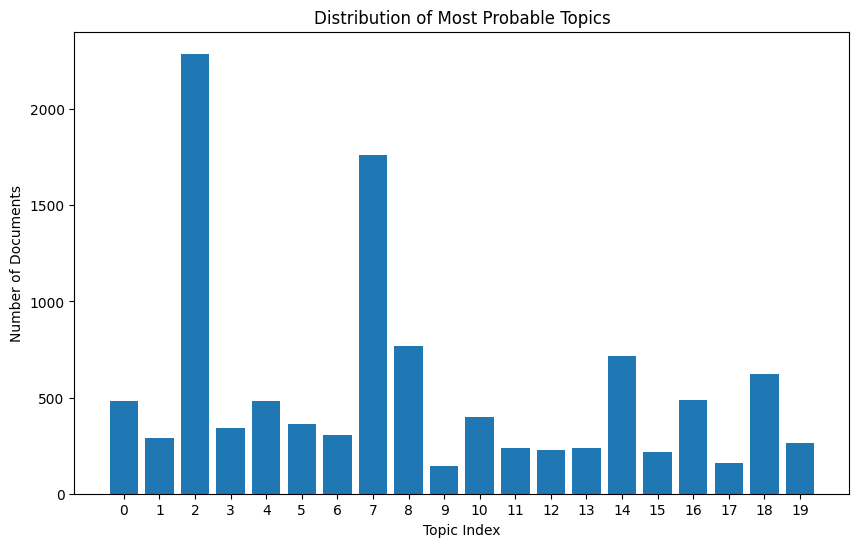

In [23]:
import matplotlib.pyplot as plt

topic_distribution = lda_model.transform(articles_words)
most_probable_topics = np.argmax(topic_distribution, axis=1)
topic_counts = np.bincount(most_probable_topics)

print("Most probable Topic for the first 10 Documents\n")
for i in range(10):
    print("{} (top topic: {})".format(articles[i].split("\n")[0], most_probable_topics[i]))

plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_counts)), topic_counts, align='center')
plt.xlabel('Topic Index')
plt.ylabel('Number of Documents')
plt.title('Distribution of Most Probable Topics')
plt.xticks(range(len(topic_counts)))
plt.show()

#### Most fitting Document
Here we found that most fitting Document for each Topic. That means the Document for the probability that it belongs to the specified topic is the highest.

In [24]:
document_topic_dist = lda_model.transform(articles_words)
most_probable_topics = np.argmax(document_topic_dist, axis=1)
most_fitting_documents = []
unique_topics = np.unique(most_probable_topics)
for topic in unique_topics:
        # Find the indices of documents with the current topic
    topic_indices = np.where(most_probable_topics == topic)[0]

        # Find the document with the highest probability for the current topic
    max_prob_index = topic_indices[np.argmax(topic_distribution[topic_indices, topic])]

        # Store the most fitting document for the current topic
    most_fitting_documents.append("Topic "+ str(topic)+", Document "+ str(max_prob_index)+", probability "+ str(document_topic_dist[max_prob_index][topic])+ ": \n" +articles[max_prob_index])

for topic_doc_combo in most_fitting_documents:
    print(topic_doc_combo)

Topic 0, Document 7403, probability 0.9746628730253242: 
U.K. MONEY MARKET GIVEN FURTHER 168 MLN STG HELP
  The Bank of England said it provided the
  money market with a further 168 mln stg of assistance to help
  offset a shortage it now estimated at 1.05 billion stg, revised
  down from 1.10 billion.
      It bought 21 mln stg of bank bills outright, 20 mln in band
  one at 10-3/8 pct and one mln in band two at 10-5/16 pct. In
  addition, it bought 98 mln stg of bills for resale on March 30
  and 49 mln stg for resale April 8 at an interest rate of
  10-7/16 pct. All these rates are the same as for today's
  earlier help.
      So far today, the bank has provided the market with
  assistance worth 646 mln stg.
      The bank also announced the rates applicable to temporary
  lending facilities rolled over today.
      The average mid-market rate for lending rolled over for one
  week is 10-15/16 pct and for two weeks 10-5/8 pct.
  


Topic 1, Document 8632, probability 0.94411117015

#### Similarity between Documents
From the inferred topic distributions, we can define the topic distance between two documents $d_1$, $d_2$ to be the Kullback-Leibler divergence between their topic distributions. We implemented a function *get_similar(doc_id,doc_topic_distribution)* that takes an integer *doc_id* representing the document index and a matrix that gives the distribution over topics for each document. The function returns a list that contains the indices of all documents in the collection ordered by their topic distance to *doc_id*. 


In [25]:
def get_similar(doc_id, doc_topic_distribution):
    # Extract the topic distribution for the specified document
    theta_d1 = doc_topic_distribution[doc_id]
    
    # Calculate Kullback-Leibler divergence with all other documents
    kl_divergences = []
    for i, theta_d2 in enumerate(doc_topic_distribution):
        kl_divergence = np.sum(theta_d1 * np.log(theta_d1 / theta_d2))
        kl_divergences.append((i, kl_divergence))
    
    # Sort documents by their topic distance to doc_id
    sorted_documents = sorted(kl_divergences, key=lambda x: x[1])
    
    # Extract and return the indices of similar documents
    similar_documents_indices = [idx for idx, _ in sorted_documents]
    
    return similar_documents_indices

In [26]:
# lda.transform(X) gives a matrix of documents with their respective topic distribution
sim_ids_1 = get_similar(7403, document_topic_dist)
print(sim_ids_1[:10])

[7403, 9236, 9252, 3287, 799, 5086, 6307, 67, 5122, 5642]


In [27]:
print("ARTICLE 7403\n\n",articles[7403])
print("ARTICLE 9236\n\n",articles[9236])

ARTICLE 7403

 U.K. MONEY MARKET GIVEN FURTHER 168 MLN STG HELP
  The Bank of England said it provided the
  money market with a further 168 mln stg of assistance to help
  offset a shortage it now estimated at 1.05 billion stg, revised
  down from 1.10 billion.
      It bought 21 mln stg of bank bills outright, 20 mln in band
  one at 10-3/8 pct and one mln in band two at 10-5/16 pct. In
  addition, it bought 98 mln stg of bills for resale on March 30
  and 49 mln stg for resale April 8 at an interest rate of
  10-7/16 pct. All these rates are the same as for today's
  earlier help.
      So far today, the bank has provided the market with
  assistance worth 646 mln stg.
      The bank also announced the rates applicable to temporary
  lending facilities rolled over today.
      The average mid-market rate for lending rolled over for one
  week is 10-15/16 pct and for two weeks 10-5/8 pct.
  


ARTICLE 9236

 BANK OF SPAIN SUSPENDS ASSISTANCE, DRAINS FUNDS
  The Bank of Spain suspende